<h1>
    <span style="float:left;"> Homework 4 </span>
    <span style="float:right;"> Brandon Hosley </span></br>
    <span style="float:left;"> Reinforcement Learning </span>
    <span style="float:right;"> DSOR 646 </span>
</h1>

## 1. SARSA Temporal Difference Control:
Consider the Farama OpenAI `Gymnasium MountainCar-v0 environment`. See the following link for a description of the environment: https://gymnasium.farama.org/environments/classic_control/mountain_car/. Solve the agent’s sequential decision problem using an implementation of the SARSA algorithm. You must encode your own implementation of the algorithm in Python. See page 130 of the course textbook for pseudocode and Lesson 10 Handout for an example implementation of SARSA using Python.

Tune your algorithm via experimentation to attain best results. Utilize a parallelized Latin Hyper-cube Sampling (LHS) design. See Lesson 9 for an example implementation. What algorithm design run parameter values attain the best performance? Which parameters appear to most impact performance? Utilize estimated expected total discounted reward (EETDR) of generated target policies at milestone episodes to evaluate results.

Test and report the best performing algorithm parameter values for your algorithm. Use tables and figures to convey your results. Execute at least 50 design runs. Execute at least 10 replications for each run. Use 1000 episodes per replication. Report Mean Time-Avg EETDR and Mean Max
EETDR to convey algorithm performance in terms quality of solution and reliability. Report the best performing, superlative policy found by your SARSA implementation across all parameter tuning design runs performed. Record and report the average times required to execute a single design run replication. When milestone testing a policy, use at least 30 episodes. Report 95% confidence interval of EETDR. Use the lower bound of the confidence interval, i.e., 95CILB, to identify a superlative policy. The 95CILB seeks to measure reliable performance. Show a scatter plot of the observed 95CILB values for average and maximum performance for each design run.


Use the following stepsize TD learning rate. The learning rate at episode n is defined as
$$ \alpha_n = \alpha_a \left(\frac{1}{(n+1)^{\alpha_b}}\right). $$


Use state-action visit counts instead of the episode number to improve performance.
Use the following exploration-exploitation ϵ-greedy rule. The probability of selecting a random
action at episode n is
$$ \epsilon_n = \epsilon_a \left(\frac{1}{(n+1)^{\epsilon_b}}\right). $$



Use state visit counts instead of the episode number to improve performance.
Test the following algorithm parameters
- $\alpha_a$: initial learning rate
- $\alpha_b$: learning rate decay (higher indicates faster decay)
- $\epsilon_a$: initial exploration probability
- $\epsilon_b$: exploration probability decay (higher indicates faster decay)
- $Q^{init}$: initial Q-values across all state-action pairs

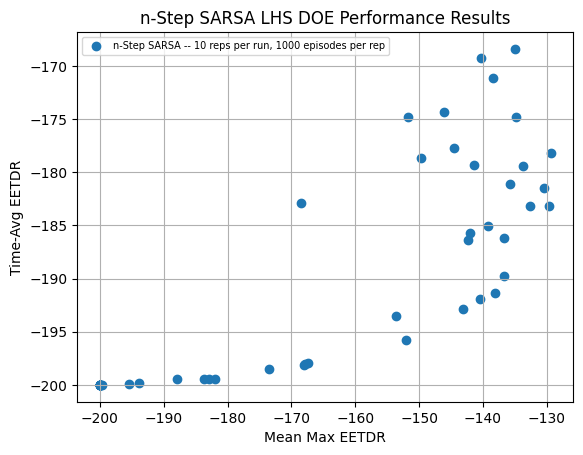

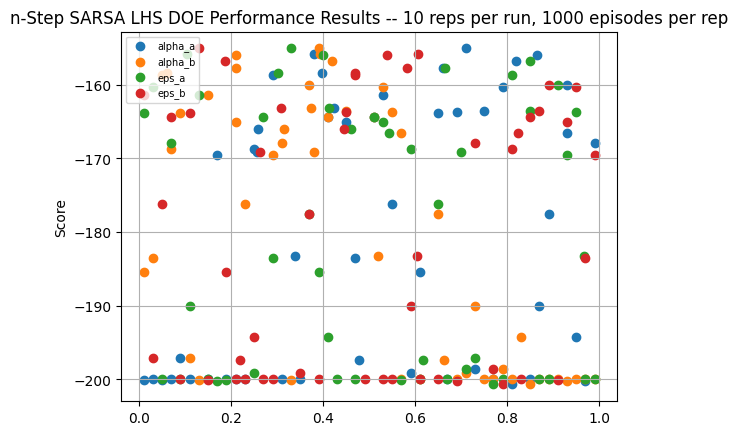




                            OLS Regression Results                            
Dep. Variable:               AlgScore   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     10.26
Date:                Sun, 26 May 2024   Prob (F-statistic):           1.39e-08
Time:                        22:33:08   Log-Likelihood:                -198.86
No. Observations:                  50   AIC:                             427.7
Df Residuals:                      35   BIC:                             456.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -200.3793     22.040  

In [1]:
import numpy as np
from time import perf_counter
from collections import deque

%rm -r __pycache__/
from HW4_functions import MDPBase, LHS_Experiment

class SARSA(MDPBase):
    name = "n-Step SARSA"

    def __init__(self, env, steps=1, **kwargs) -> None:
        super().__init__(env, **kwargs)
        self.steps = steps if type(steps) == int else 2**int(6*steps)
        self.algorithm_name = f'{steps}-step SARSA'

    def train(self, num_replications, num_episodes, verbose=False):
        time_start = perf_counter()
        # perform each algorithm replication
        for z in range(num_replications): # Z
            Q = (self.qinit*np.ones(self.SAsize)*np.diff(self.qrange)[0]+self.qrange[0]) # Q-table
            C = np.zeros(self.SAsize)   # state-action counter

            print(f"\n{self.steps} - step SARSA(alpha_a = {self.alpha_a:<3.2f}, alpha_b="
                  + f"{self.alpha_b:<3.2f}, eps_a={self.eps_a:<3.2f}, eps_b={self.eps_b:<3.2f}, "
                  + f"|S|/d {self.Sintervals}, qinit={self.qinit}, rep {z}...")

            for m in range(num_episodes): # M
                np.random.seed(int(m + 1e6*z + 1e5*self.offset))    # Set rng seed
                terminated,truncated = False,False                  # Episode complete flags
                Gm = 0                                              # Episode reward

                state_continuous = self.env.reset(seed=int(z*1e6+m))[0]
                state = self.phi(state_continuous)      # continuous state to discrete
                state_queue = deque([state])            # Initialize state array, records of states
                cs = np.sum(C[tuple(state)])            # Compute times state has been visited

                # Select action based on epsilon-greedy exploration mechanism
                if np.random.rand() > self.epsilon(cs):     # With probability epsilon:
                    action = np.argmax(Q[tuple(state)])     # Act greedy, using Q
                else:
                    action = self.env.action_space.sample() # Act randomly to explore

                action_queue = deque([action])  # Initialize action array, record of actions
                reward_queue = deque([])        # Initialize reward array, record of rewards

                # SARSA main loop (first nml transitions)
                for _ in range(self.steps - 1):
                    # Apply action and observe system information
                    next_state_cont, reward, terminated, truncated, _ = self.env.step(action)
                    next_state = self.phi(next_state_cont)  # Continuous state to discrete
                    reward_queue.append(reward)             # Append reward to reward array
                    Gm += reward                            # Update episode cumulative reward
                    state_queue.append(next_state)          # Append next state to state array
                    cs = np.sum(C[tuple(next_state)])       # State visit count

                    # Select action based on epsilon-greedy exploration mechanism
                    if np.random.rand() > self.epsilon(cs):             # With probability epsilon:
                        next_action = np.argmax(Q[tuple(next_state)])   # Act greedy, using Q
                    else:
                        next_action = self.env.action_space.sample()    # Act randomly to explore
                    action_queue.append(next_action)

                # SARSA main loop (first nml transitions until end of episode)
                while not (terminated or truncated):
                    # Apply action and observe system information
                    next_state_cont, reward, terminated, truncated, _ = env.step(action_queue[-1])
                    next_state = self.phi(next_state_cont)  # Continuous state to discrete
                    state_queue.append(next_state)          # Append next state to state array
                    reward_queue.append(reward)             # Append reward to reward array
                    Gm += reward                            # Update episode cumulative reward
                    cs = np.sum(C[tuple(next_state)])       # State visit count

                    # select action based on epsilon-greedy exploration mechanism
                    if np.random.rand() > self.epsilon(cs):             # With probability epsilon:
                        next_action = np.argmax(Q[tuple(next_state)])   # Act greedy, using Q
                    else:
                        next_action = self.env.action_space.sample()    # Act randomly to explore
                    action_queue.append(next_action)

                    # temporal difference learning mechanism
                    qhat = (np.dot(reward_queue, self.gamma**np.arange(len(reward_queue))) 
                            + (1-terminated) * self.gamma**len(reward_queue) 
                            * Q[tuple(next_state) + (next_action,)])

                    # SARSA main loop (episode complete, update for last nml transitions)
                    last_state_action = tuple(state_queue[-1]) + (action_queue[-1],) #in trajectory
                    while reward_queue:
                        # update state-action counter (for earliest state-action in queue) and Q
                        state_action = tuple(state_queue[0]) + (action_queue[0],)
                        C[state_action] += 1
                        csa = C[state_action]   # Count of state-action pair visits
                        Q[state_action] =(1-self.alpha(csa))*Q[state_action] + self.alpha(csa)*qhat

                        state_queue.popleft()   #
                        action_queue.popleft()  # update by removing oldest values
                        reward_queue.popleft()  #

                        # compute qhat
                        qhat = (np.dot(reward_queue, self.gamma**np.arange(len(reward_queue))) 
                               + (1-terminated)*self.gamma**len(reward_queue)*Q[last_state_action])

                    # record performance
                    if verbose: print(f"In Episode: {m}, Cumulative reward: {Gm}")
                    self.Gzm.append((z, Gm))
                    
                # test current policy (as represented by current Q) every test_freq episodes
                if m % self.test_freq == 0:
                    mean, hw = self.evaluate_policy_test(Q, self.num_test_reps)
                    self.GzmTest.append((z,m, mean, hw))
                    # update best scores if necessary
                    if verbose:
                        self.update_and_print(m,mean,hw,Q)
                    else:
                        self.update_best_scores(mean,hw,Q)

            # last test of current algorithm replication
            mean, hw = self.evaluate_policy_test(Q, self.num_test_reps)
            self.GzmTest.append((z, num_episodes, mean, hw))

            # update best EETDR scores if necessary
            if verbose:
                self.update_and_print(m,mean,hw,Q)
            else:
                self.update_best_scores(mean,hw,Q)

        time_elapsed = perf_counter() - time_start
        print(f"Executed {num_replications} algorithm reps in {time_elapsed:0.4f} seconds.")
        
        self.total_training_reps += num_replications
        self.total_episodes += num_episodes
        # Update execution time record
        total_time = (self.total_training_reps * self.avg_execution_time) + time_elapsed
        self.avg_execution_time = total_time / self.total_training_reps


import gymnasium as gym

#env = gym.make('MountainCar-v0')
#one_sarsa = SARSA(env)
#one_sarsa.train(num_replications=5, num_episodes=200)
#one_sarsa.get_results()
#one_sarsa.show_results()

env = gym.make('MountainCar-v0')
features = ["alpha_a", "alpha_b", "eps_a", "eps_b"]
sarsa_experiment = LHS_Experiment(SARSA,env,features)
sarsa_experiment.parallel_lhs()
sarsa_experiment.export_results()
sarsa_experiment.plot_results()
sarsa_experiment.plot_param_comparison()
sarsa_experiment.anova()

## 2. Q-learning Temporal Difference Control:
Consider the Farama OpenAI Gymnasium `MountainCar-v0 environment`. Solve the agent’s sequential decision problem using the Q-learning algorithm, an off-policy temporal difference (TD) control solution procedure. You must encode your own implementation of the algorithm in Python. See page 131 of the course textbook for pseudocode. Perform the same analysis as described for SARSA above.

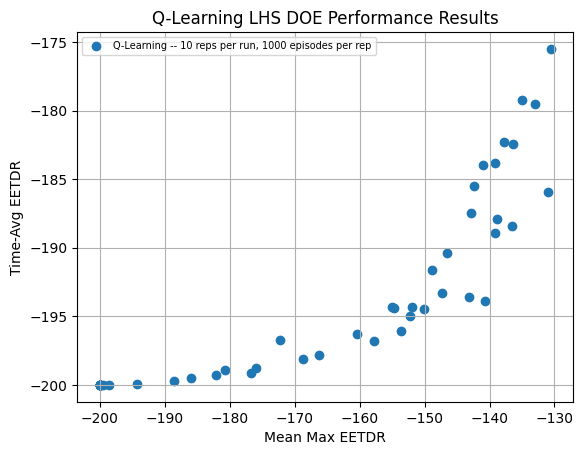

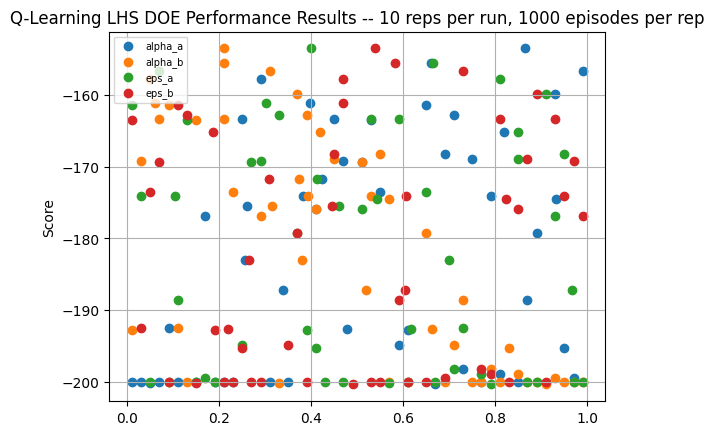




                            OLS Regression Results                            
Dep. Variable:               AlgScore   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     15.11
Date:                Sun, 26 May 2024   Prob (F-statistic):           7.14e-11
Time:                        22:52:59   Log-Likelihood:                -185.15
No. Observations:                  50   AIC:                             400.3
Df Residuals:                      35   BIC:                             429.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -205.8816     16.754  

In [6]:
import numpy as np
from time import perf_counter
from collections import deque

#%rm -r __pycache__/
from HW4_functions import MDPBase, LHS_Experiment

class QLearning(MDPBase):
    name = "Q-Learning"

    def __init__(self, env, **kwargs) -> None:
        super().__init__(env, **kwargs)
        self.algorithm_name = self.name

    def train(self, num_replications, num_episodes, verbose=False):
        time_start = perf_counter()
        for z in range(num_replications):
            Q = (self.qinit*np.ones(self.SAsize)*np.diff(self.qrange)[0]+self.qrange[0]) # Q-table
            C = np.zeros(self.SAsize)

            print(f"Q-learning (alpha_a = {self.alpha_a:<3.2f}, alpha_b="
                  + f"{self.alpha_b:<3.2f}, eps_a={self.eps_a:<3.2f}, eps_b={self.eps_b:<3.2f}, "
                  + f"|S|/d {self.Sintervals}, qinit={self.qinit}, rep {z}...")

            for m in range(num_episodes): # M
                np.random.seed(int(m + 1e6*z + 1e5*self.offset))    # Set rng seed
                terminated,truncated = False,False                  # Episode complete flags
                Gm = 0                                              # Episode reward

                state_continuous = self.env.reset(seed=int(z*1e6+m))[0]
                state = self.phi(state_continuous)      # continuous state to discrete
                state_queue = deque([state])            # Initialize state array, records of states
                cs = np.sum(C[tuple(state)])            # Compute times state has been visited

                # Select action based on epsilon-greedy exploration mechanism
                if np.random.rand() > self.epsilon(cs):     # With probability epsilon:
                    action = np.argmax(Q[tuple(state)])     # Act greedy, using Q
                else:
                    action = self.env.action_space.sample() # Act randomly to explore

                action_queue = deque([action])  # Initialize action array, record of actions
                reward_queue = deque([])        # Initialize reward array, record of rewards

                # Q-learning main loop
                while not (terminated or truncated):
                    next_state_cont, reward, terminated, truncated, _ = self.env.step(action)
                    next_state = self.phi(next_state_cont)  # Continuous state to discrete
                    state_queue.append(next_state)          # Append next state to state array
                    reward_queue.append(reward)             # Append reward to reward array
                    Gm += reward                            # Update episode cumulative reward
                    cs = np.sum(C[tuple(next_state)])       # State visit count

                    # select action based on epsilon-greedy exploration mechanism
                    if np.random.rand() > self.epsilon(cs):             # With probability epsilon:
                        next_action = np.argmax(Q[tuple(next_state)])   # Act greedy, using Q
                    else:
                        next_action = self.env.action_space.sample()    # Act randomly to explore
                    action_queue.append(next_action)

                    best_next_action = np.argmax(Q[tuple(next_state)])
                    td_target = reward + self.gamma * Q[tuple(next_state) + (best_next_action,)]
                    state_action = tuple(state_queue[-2]) + (action_queue[-2],)
                    C[state_action] += 1
                    csa = C[state_action]   # Count of state-action pair visits
                    Q[state_action] = (1-self.alpha(csa))*Q[state_action]+self.alpha(csa)*td_target

                    action = next_action

                if verbose: print(f"In Episode: {m}, Cumulative reward: {Gm}")
                self.Gzm.append((z, Gm))

                # test current policy (as represented by current Q) every test_freq episodes
                if m % self.test_freq == 0:
                    mean, hw = self.evaluate_policy_test(Q, self.num_test_reps)
                    self.GzmTest.append((z, m, mean, hw))
                    # update best scores if necessary
                    if verbose:
                        self.update_and_print(m, mean, hw, Q)
                    else:
                        self.update_best_scores(mean, hw, Q)

            # last test of current algorithm replication
            mean, hw = self.evaluate_policy_test(Q, self.num_test_reps)
            self.GzmTest.append((z, num_episodes, mean, hw))

            # update best EETDR scores if necessary
            if verbose:
                self.update_and_print(num_episodes, mean, hw, Q)
            else:
                self.update_best_scores(mean, hw, Q)

        time_elapsed = perf_counter() - time_start
        print(f"Executed {num_replications} algorithm reps in {time_elapsed:0.4f} seconds.")

        self.total_training_reps += num_replications
        self.total_episodes += num_episodes
        # Update execution time record
        total_time = (self.total_training_reps * self.avg_execution_time) + time_elapsed
        self.avg_execution_time = total_time / self.total_training_reps


import gymnasium as gym

#env = gym.make('MountainCar-v0')
#q_learn = QLearning(env)
#q_learn.train(num_replications=5, num_episodes=200)
#q_learn.get_results()
#q_learn.show_results()
#q_learn.export_results()

env = gym.make('MountainCar-v0')
features = ["alpha_a", "alpha_b", "eps_a", "eps_b"]
q_learning_experiment = LHS_Experiment(QLearning,env,features)
q_learning_experiment.parallel_lhs()
q_learning_experiment.export_results()
q_learning_experiment.plot_results()
q_learning_experiment.plot_param_comparison()
q_learning_experiment.anova()

## 3. Expected SARSA or Double Q-learning:
Consider the Farama OpenAI Gymnasium `MountainCar-v0 environment`. Solve the agent’s sequential decision problem using either the Expected SARSA Algorithm (discussed in Section 6.6) or the Double Q-learning Algorithm (discussed in Section 6.7 with pseudocode on p.136). You must encode your own implementation of the algorithm in Python. Perform the same analysis as described for SARSA above.


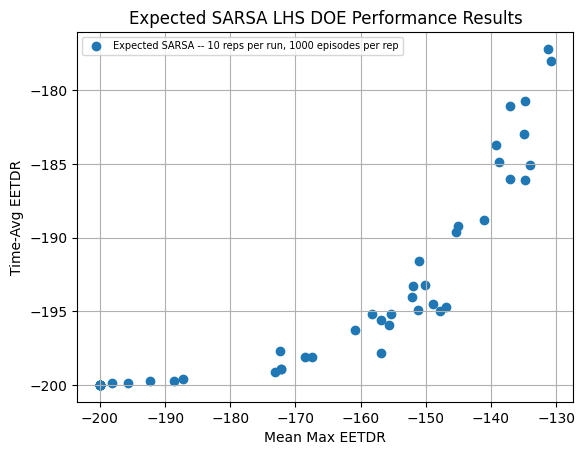

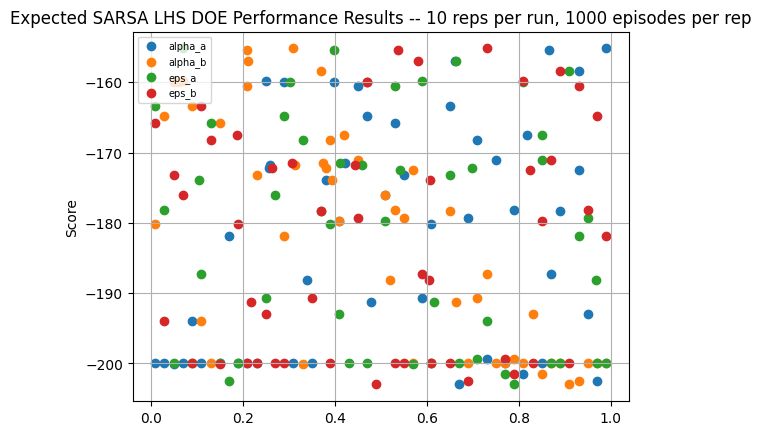




                            OLS Regression Results                            
Dep. Variable:               AlgScore   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     21.50
Date:                Sun, 26 May 2024   Prob (F-statistic):           4.05e-13
Time:                        23:03:29   Log-Likelihood:                -178.16
No. Observations:                  50   AIC:                             386.3
Df Residuals:                      35   BIC:                             415.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -198.5730     14.569  

In [7]:
import numpy as np
from time import perf_counter
from collections import deque

#%rm -r __pycache__/
from HW4_functions import MDPBase, LHS_Experiment

class ExpectedSARSA(MDPBase):
    name = "Expected SARSA"

    def __init__(self, env, **kwargs) -> None:
        super().__init__(env, **kwargs)
        self.algorithm_name = self.name

    def train(self, num_replications, num_episodes, verbose=False):
        time_start = perf_counter()
        for z in range(num_replications):
            Q = (self.qinit*np.ones(self.SAsize)*np.diff(self.qrange)[0]+self.qrange[0]) # Q-table
            C = np.zeros(self.SAsize)

            print(f"Expected SARSA (alpha_a = {self.alpha_a:<3.2f}, alpha_b="
                  f"{self.alpha_b:<3.2f}, eps_a={self.eps_a:<3.2f}, eps_b={self.eps_b:<3.2f}, "
                  f"|S|/d {self.Sintervals}, qinit={self.qinit}, rep {z}...")

            for m in range(num_episodes): # M
                np.random.seed(int(m + 1e6*z + 1e5*self.offset))    # Set rng seed
                terminated,truncated = False,False                  # Episode complete flags
                Gm = 0                                              # Episode reward

                state_continuous = self.env.reset(seed=int(z*1e6 + m))[0]
                state = self.phi(state_continuous)      # continuous state to discrete
                state_queue = deque([state])            # Initialize state array, records of states
                cs = np.sum(C[tuple(state)])            # Compute times state has been visited

                # Select action based on epsilon-greedy exploration mechanism
                if np.random.rand() > self.epsilon(cs):     # With probability epsilon:
                    action = np.argmax(Q[tuple(state)])     # Act greedy, using Q
                else:
                    action = self.env.action_space.sample() # Act randomly to explore

                action_queue = deque([action])  # Initialize action array, record of actions
                reward_queue = deque([])        # Initialize reward array, record of rewards

                # Expected-SARSA main loop
                while not (terminated or truncated):
                    next_state_cont, reward, terminated, truncated, _ = self.env.step(action)
                    next_state = self.phi(next_state_cont)  # Continuous state to discrete
                    state_queue.append(next_state)          # Append next state to state array
                    reward_queue.append(reward)             # Append reward to reward array
                    Gm += reward                            # Update episode cumulative reward
                    cs = np.sum(C[tuple(next_state)])       # State visit count

                    # select action based on epsilon-greedy exploration mechanism
                    if np.random.rand() > self.epsilon(cs):             # With probability epsilon:
                        next_action = np.argmax(Q[tuple(next_state)])   # Act greedy, using Q
                    else:
                        next_action = self.env.action_space.sample()    # Act randomly to explore
                    action_queue.append(next_action)

                    # Compute expected Q-value for the next state
                    action_probabilities = (np.ones(self.env.action_space.n) 
                                            * self.epsilon(cs) / self.env.action_space.n)
                    best_action = np.argmax(Q[tuple(next_state)])
                    action_probabilities[best_action] += 1 - self.epsilon(cs)
                    expected_q = np.sum(action_probabilities * Q[tuple(next_state)])

                    td_target = reward + self.gamma*expected_q
                    state_action = tuple(state_queue[-2]) + (action_queue[-2],)
                    C[state_action] += 1
                    csa = C[state_action]   # Count of state-action pair visits
                    Q[state_action] = (1-self.alpha(csa))*Q[state_action]+self.alpha(csa)*td_target

                    action = next_action

                if verbose: print(f"In Episode: {m}, Cumulative reward: {Gm}")
                self.Gzm.append((z, Gm))

                # test current policy (as represented by current Q) every test_freq episodes
                if m % self.test_freq == 0:
                    mean, hw = self.evaluate_policy_test(Q, self.num_test_reps)
                    self.GzmTest.append((z, m, mean, hw))
                    # update best scores if necessary
                    if verbose:
                        self.update_and_print(m, mean, hw, Q)
                    else:
                        self.update_best_scores(mean, hw, Q)

            # last test of current algorithm replication
            mean, hw = self.evaluate_policy_test(Q, self.num_test_reps)
            self.GzmTest.append((z, num_episodes, mean, hw))

            # update best EETDR scores if necessary
            if verbose:
                self.update_and_print(num_episodes, mean, hw, Q)
            else:
                self.update_best_scores(mean, hw, Q)

        time_elapsed = perf_counter() - time_start
        print(f"Executed {num_replications} algorithm reps in {time_elapsed:0.4f} seconds.")

        self.total_training_reps += num_replications
        self.total_episodes += num_episodes
        # Update execution time record
        total_time = (self.total_training_reps * self.avg_execution_time) + time_elapsed
        self.avg_execution_time = total_time / self.total_training_reps


import gymnasium as gym

#env = gym.make('MountainCar-v0')
#e_sarsa = ExpectedSARSA(env)
#e_sarsa.train(num_replications=5, num_episodes=200)
#e_sarsa.get_results()
#e_sarsa.show_results()

env = gym.make('MountainCar-v0')
features = ["alpha_a", "alpha_b", "eps_a", "eps_b"]
e_sarsa_experiment = LHS_Experiment(ExpectedSARSA,env,features)
e_sarsa_experiment.parallel_lhs()
e_sarsa_experiment.export_results()
e_sarsa_experiment.plot_results()
e_sarsa_experiment.plot_param_comparison()
e_sarsa_experiment.anova()

## 4. $n$-step SARSA:
Consider the Farama OpenAI Gymnasium MountainCar-v0 environment. Solve the agent’s sequential decision problem using the n-step SARSA algorithm. You must encode your own implementation of the algorithm in Python. See page 147 of the course textbook for pseudocode. See Lesson 12 Handout for an example implementation of n-step SARSA using Python. Perform the same analysis as described for SARSA above. You must test different values of step parameter n.

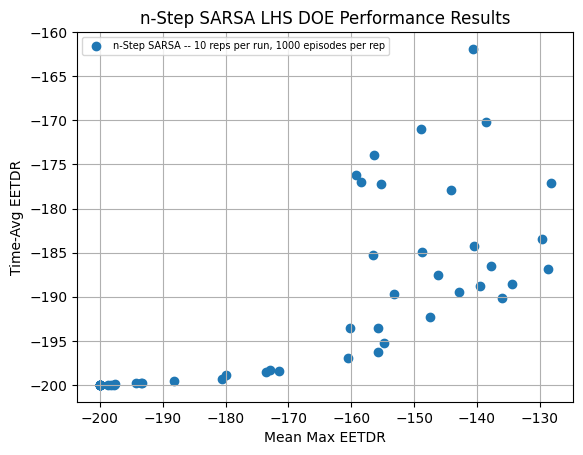

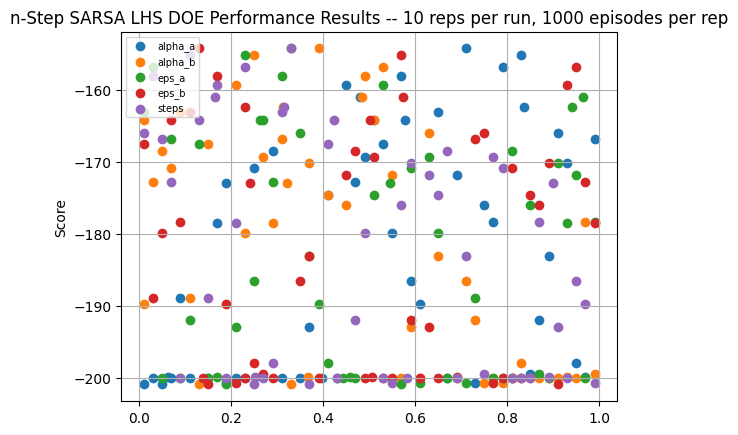




                            OLS Regression Results                            
Dep. Variable:               AlgScore   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     7.188
Date:                Sun, 26 May 2024   Prob (F-statistic):           1.30e-06
Time:                        22:43:37   Log-Likelihood:                -190.83
No. Observations:                  50   AIC:                             423.7
Df Residuals:                      29   BIC:                             463.8
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -171.1592     25.460  

In [4]:
env = gym.make('MountainCar-v0')
features = ["alpha_a", "alpha_b", "eps_a", "eps_b", "steps"]
sarsa_experiment = LHS_Experiment(SARSA,env,features)
sarsa_experiment.parallel_lhs()
sarsa_experiment.export_results()
sarsa_experiment.plot_results()
sarsa_experiment.plot_param_comparison()
sarsa_experiment.anova()

## 5. Evaluate the Benchmark Momentum Policy:
In this fixed benchmark policy, the agent accelerates in the direction it is currently moving. This
policy is expressed as follows.
$$ \pi(s) = 
\begin{cases}
    0 & \text{if } s^{velocity} < 0 \\
    2 & \text{otherwise}
\end{cases}
$$
Evaluate the policy by simulating its execution for 100 trials then taking the average. This is one replication. Perform 30 replications, reporting the average and 95% confidence interval half-width from the 30 test replication averages.

Benchmark Momentum Policy rep 0...
Benchmark Momentum Policy rep 1...
Benchmark Momentum Policy rep 2...
Benchmark Momentum Policy rep 3...
Benchmark Momentum Policy rep 4...
Executed 5 algorithm reps in 1.0180 seconds.


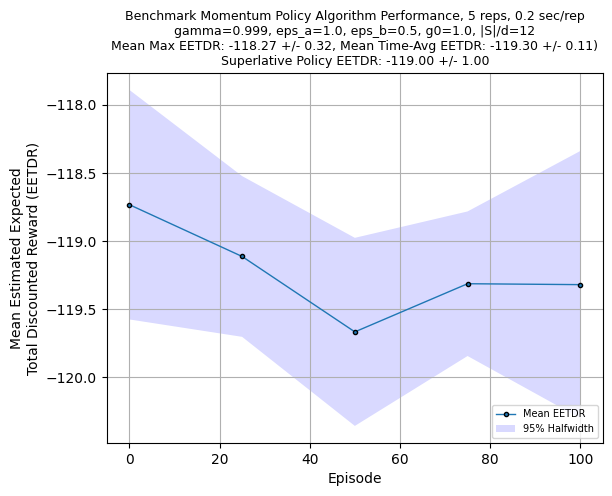

In [8]:
import numpy as np
from time import perf_counter
from collections import deque

#%rm -r __pycache__/
from HW4_functions import MDPBase, LHS_Experiment

class Momentum(MDPBase):
    name = "Benchmark Momentum Policy"

    def __init__(self, env, **kwargs) -> None:
        super().__init__(env, **kwargs)
        self.algorithm_name = self.name

    def train(self, num_replications, num_episodes, verbose=False):
        time_start = perf_counter()
        for z in range(num_replications):
            print(f"Benchmark Momentum Policy rep {z}...")

            for m in range(num_episodes): # M
                np.random.seed(int(m + 1e6*z + 1e5*self.offset))    # Set rng seed
                terminated,truncated = False,False                  # Episode complete flags
                Gm = 0                                              # Episode reward

                # Benchmark Main Loop
                state_continuous = self.env.reset(seed=int(z*1e6 + m))[0]
                while not (terminated or truncated):
                    position, velocity = state_continuous
                    action = 0 if velocity < 0 else 2
                    state_continuous, reward, terminated, truncated, _ = self.env.step(action)
                    Gm += reward

                if verbose: print(f"In Episode: {m}, Cumulative reward: {Gm}")
                self.Gzm.append((z, Gm))

                if m % self.test_freq == 0:
                    mean, hw = self.evaluate_policy_test(None, self.num_test_reps)
                    self.GzmTest.append((z, m, mean, hw))
                    if verbose:
                        self.update_and_print(m, mean, hw, None)
                    else:
                        self.update_best_scores(mean, hw, None)

            mean, hw = self.evaluate_policy_test(None, self.num_test_reps)
            self.GzmTest.append((z, num_episodes, mean, hw))
            if verbose:
                self.update_and_print(num_episodes, mean, hw, None)
            else:
                self.update_best_scores(mean, hw, None)

        time_elapsed = perf_counter() - time_start
        print(f"Executed {num_replications} algorithm reps in {time_elapsed:0.4f} seconds.")

        self.total_training_reps += num_replications
        self.total_episodes += num_episodes
        total_time = (self.total_training_reps * self.avg_execution_time) + time_elapsed
        self.avg_execution_time = total_time / self.total_training_reps


    def evaluate_policy_test(self, Q, num_test_reps):
        cumulative_rewards = []
        for _ in range(num_test_reps):
            terminated, truncated = False, False
            state_continuous = self.env.reset()[0]
            total_reward = 0
            while not (terminated or truncated):
                position, velocity = state_continuous
                action = 0 if velocity < 0 else 2
                state_continuous, reward, terminated, truncated, _ = self.env.step(action)
                total_reward += reward
            cumulative_rewards.append(total_reward)

        mean_reward = np.mean(cumulative_rewards)
        hw = 1.96 * np.std(cumulative_rewards) / np.sqrt(num_test_reps)  # 95% CI half-width
        return mean_reward, hw


    def find_superlative(self):
        return None, -119, 1.0


import gymnasium as gym

env = gym.make('MountainCar-v0')
benchmark = Momentum(env)
benchmark.train(num_replications=5, num_episodes=100)
#benchmark.get_results()
benchmark.show_results()

## 6. Compare the performance of the four algorithms with respect to quality of solution, reliability, and computational expense.
Which algorithm is best for this problem? Justify your claim. 
Create a single color-coded and/or icon-differentiated scatter 
plot that depicts the algorithms’ results with respect to mean and max
95CILB measures of reliable average and maximum performance. 
Also create a single learning curve figure showing the best learning curve (associated with the best parameter design run) for each algorithm. 
Create a summary statistics table to compactly represent your results. Provide an accompanying narrative to support your claims. Make sure you explain your key observations. Can the algorithms determine superlative policies that outperform the benchmark Momentum Policy? (I hope so.)


What was the most challenging aspect of solving the MountainCar-v0 environment using these RL
approaches? What novel algorithm design mechanisms would you suggest to improve performance?


1 - step SARSA(alpha_a = 0.71, alpha_b=0.39, eps_a=0.33, eps_b=0.13, |S|/d 11, qinit=1.0, rep 0...

1 - step SARSA(alpha_a = 0.71, alpha_b=0.39, eps_a=0.33, eps_b=0.13, |S|/d 11, qinit=1.0, rep 1...

1 - step SARSA(alpha_a = 0.71, alpha_b=0.39, eps_a=0.33, eps_b=0.13, |S|/d 11, qinit=1.0, rep 2...

1 - step SARSA(alpha_a = 0.71, alpha_b=0.39, eps_a=0.33, eps_b=0.13, |S|/d 11, qinit=1.0, rep 3...

1 - step SARSA(alpha_a = 0.71, alpha_b=0.39, eps_a=0.33, eps_b=0.13, |S|/d 11, qinit=1.0, rep 4...

1 - step SARSA(alpha_a = 0.71, alpha_b=0.39, eps_a=0.33, eps_b=0.13, |S|/d 11, qinit=1.0, rep 5...

1 - step SARSA(alpha_a = 0.71, alpha_b=0.39, eps_a=0.33, eps_b=0.13, |S|/d 11, qinit=1.0, rep 6...

1 - step SARSA(alpha_a = 0.71, alpha_b=0.39, eps_a=0.33, eps_b=0.13, |S|/d 11, qinit=1.0, rep 7...

1 - step SARSA(alpha_a = 0.71, alpha_b=0.39, eps_a=0.33, eps_b=0.13, |S|/d 11, qinit=1.0, rep 8...

1 - step SARSA(alpha_a = 0.71, alpha_b=0.39, eps_a=0.33, eps_b=0.13, |S|/d 11, qinit=1.0, rep 9...


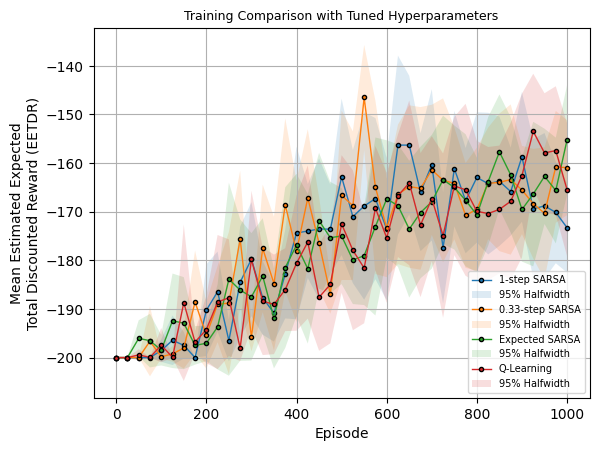

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import t

env = gym.make('MountainCar-v0')
tuned_algos = [
    SARSA(env, alpha_a = 0.71, alpha_b = 0.39, eps_a = 0.33, eps_b = 0.13),
    SARSA(env, alpha_a = 0.71, alpha_b = 0.39, eps_a = 0.33, eps_b = 0.13, steps = 0.33), # 2-step
    ExpectedSARSA(env, alpha_a = 0.99, alpha_b = 0.31, eps_a = 0.07, eps_b = 0.73),
    QLearning(env, alpha_a = 0.87, alpha_b = 0.21, eps_a = 0.40, eps_b = 0.54)
]
reps = 10
eps = 1000

plt.figure(0)
plt.xlabel('Episode')
plt.ylabel('Mean Estimated Expected\nTotal Discounted Reward (EETDR)')
plt.title("Training Comparison with Tuned Hyperparameters", fontsize =9)

for algo in tuned_algos:
    algo.train(num_replications=reps, num_episodes=eps)
    Z = algo.total_training_reps
    M = algo.total_episodes
    X = np.arange(0,M+1,algo.test_freq)

    npGzmTest = np.array(algo.GzmTest)
    size = np.shape(npGzmTest)

    TestEETDR = np.reshape(npGzmTest[:,2],(Z,int(size[0]/Z)))

    avgTestEETDR = np.mean(TestEETDR, axis=0)
    avgTestSE = np.std(TestEETDR,axis=0)/np.sqrt(Z)
    avgTestHW = t.ppf(1-0.05/2,Z-1)*avgTestSE
    
    plt.plot(X, avgTestEETDR, marker='o', ms=3, mec='k', linewidth=1, label=algo.algorithm_name)
    plt.fill_between(X, avgTestEETDR+avgTestHW, avgTestEETDR-avgTestHW, linestyle = '--',
                    linewidth=0.5, alpha=0.15, label='95% Halfwidth')


plt.grid(which='both')
plt.legend(loc="lower right",fontsize=7)


plt.show()
			